<a href="https://colab.research.google.com/github/yuribreion1/pandas/blob/main/IT_Incidents_Labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
macimottin_it_incidents_path = kagglehub.dataset_download('macimottin/it-incidents')

print('Data source import complete.')


# Classification of IT Incidents

In this Notebook we will create a Machine Learning model to classify IT Incidents based on the description of the incident and the Caller (person who opened the Incident), as our features.

## Importing the Training Dataset
In the below instruction we will call pandas and import our training dataset. We will also plot the tail of our dataset for our previous analysis.

In [ ]:
# Import pandas package
import pandas as pd

#Import the training dataset and show it's tail
training_dataset = pd.read_excel("/kaggle/input/it-incidents/Incidents_Test_Database.xlsx")
training_dataset.tail()

## Vectorize the Incidents Descriptions
In order to use the Incident Description as a feature in our Machine Learning Model, we will need to transform the string into a vector, so the data will be "readable" by our model. For this specific model, we will be transforming the Incident Description using TF-IDF model, that will transform the data into a CSR Matrix (Compressed Sparse Row Matrix).

*You can find rich content about strings vectorization in the following link:*  
https://towardsdatascience.com/getting-started-with-text-vectorization-2f2efbec6685

In [ ]:
#Import TF-IDF package from Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

#Separate the description in a pandas Series
inc_description = training_dataset['description']

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform the input variable into a TF-IDF matrix
vec_description = vectorizer.fit_transform(inc_description)

## Transform the CSR Matrix into a pandas Data Frame
Since we will be using two features as the inputs of our Machine Learning Model, we will need to have the 'Incident Description' and the 'Caller' in the same data frame, to be used by the model. For this reason we will tranform the CSR Matrix into a pandas data frame, then we will be merging the Caller data in it prior to train our model.

In [ ]:
#Import scipy package to work with a csr matrix
from scipy.sparse import csr_matrix

#Transform the spase matrix into a data frame and show it's tail
vec_desc_df = pd.DataFrame.sparse.from_spmatrix(vec_description)
vec_desc_df.tail()

## Transform the vectorized description data frame column names into strings
You may have noticed that the vectorized data frame created in the previous instructions, were all named with integers in the column names. In the latest python versions a data frame with integer as the name of the columns cannot be processed. For this reason I added the following code to transform the columns into strings. First we create a loop function to create a dictionary to store the strings to replace the names in the data frame. After that, we use the pandas function 'rename' to replace the column names by the data stored in the dictionary created previously.

In [ ]:
# Get the quantity of columns from 'vec_desc_df' data frame
num_cols = vec_desc_df.shape[1]

# Create a dictionary to store the new column names
col_names = {}
for i in range(num_cols):
    col_names[i] = 'col_' + str(i)

# Rename the columns with the new values stored in the dictionary
vec_desc_df = vec_desc_df.rename(columns=col_names)
vec_desc_df.tail()

## Transforming the 'Caller' Column into a Dummy Table
The 'Caller' column is considered categorical data, and we will need to treat it as well in order to make the data 'readable' within our model. A way to make this data readable by our model is to tranform the data into a dummy table. For this specific scenario, we will use a technique called One-Hot-Encoder.

*You can find detailed information about encoding categorical variables in the following link:*  
https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

In [ ]:
# Get 'Caller' unique values from the main data frame
Caller_only = training_dataset['caller'].astype(str)
Caller_only_uniques = Caller_only.drop_duplicates()
Caller_final = pd.DataFrame({'caller':Caller_only_uniques})

# Creating the dummy codes for the Callers
dum_df = pd.get_dummies(Caller_final, columns=["caller"], prefix=["Caller"])
Caller_final = Caller_final.join(dum_df)
Caller_final

## Left Join the Vectorized Incident Descriptions Data Frame with the Caller Dummy Table
Now that we already transformed the Incident Descriptions into vectors and the Caller into a dummy table, we need make both data frames into a single one, that will be processed in the model as the input variables. We will be doing that in two steps:

**1. Assign the Caller column in the vectorized description data frame**  
Since the vectorized data frame was created respecting the dataset order and maintained the same quantity of rows, we will be assigning the Caller column from the dataset, as is.

**2. Left Joing the Caller Dummy table columns in the vectorized description data frame**   
After having the Caller in the vectorized description data frame, we will be using this column as the key to left join the dummy table values, to generate the final features dataframe.

<span style="color:blue;">The result of the following code is the final features data frame, and the data is ready to run in the model!</span>

In [ ]:
# Assign the 'Caller' column in the vectorized description data frame
vec_desc_df = pd.concat([vec_desc_df, Caller_only],axis=1)

# Left join the dummy table information in the vectorized description data frame and drop the 'caller' column from the final result
features_final = vec_desc_df.merge(Caller_final, on='caller', how='left')
features_final = features_final.drop('caller',axis=1)
features_final.tail()

## Train the dataset with a Logistic Regression Model
In this Machine Learning application we will be using a Logistic Regression model to predict the labeling of new incidents.

*You can find detailed information about Logistic Regression in the following link:*  
https://www.kdnuggets.com/2022/07/logistic-regression-work.html

In [ ]:
# Import required packages for the dataset training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assign the labels into a pandas Series, to be used in the Model
y = training_dataset['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_final, y, test_size=0.2, random_state=42)

# Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Check the Models Accurracy and print it to the user
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Predict the labels of new Incidents
Now that we have the dataset trained, we may test the Artificial Intelligence we generated with the model to predict a few new Incidents that occured and were not yet labeled. The model will predict their labels!

## Load not labeled Incidents dataset
In the following instruction, we are loading a few incidents that are not yet labeled.

In [ ]:
# Import new incidents and print it's tail
new_incidents = pd.read_excel("/kaggle/input/it-incidents/new_incidents.xlsx")
new_incidents.drop('label', axis=1, inplace=True)
new_incidents.tail()

## Format the New Incidents dataset inputs like the training dataset
In order to use the model to predict the labels for new incidents, we will need to transform the inputs of the new incidents in the same way we did for the training data set. In the following code instructions I will do this in a resumed way, since the full explanation was already detailed in this Notebook, in the previous instructions.

In [ ]:
# Vectorize the description of the new incidents
new_data_vectorized = vectorizer.transform(new_incidents['description'])
vec_desc_df2 = pd.DataFrame.sparse.from_spmatrix(new_data_vectorized)
vec_desc_df2.tail()

In [ ]:
# Change the column names from the vectorized description data frame
num_cols = vec_desc_df2.shape[1]

col_names = {}
for i in range(num_cols):
    col_names[i] = 'col_' + str(i)

vec_desc_df2 = vec_desc_df2.rename(columns=col_names)
vec_desc_df2.tail()

In [ ]:
# Bring the 'Caller' to the vectorized descriptions dataframe
new_callers = new_incidents['caller']
semi = pd.concat([vec_desc_df2, new_callers], axis=1)
semi.tail()

In [ ]:
# Merge the Dummy table information with the vectorized descriptions data frame
new_inc_final = semi.merge(Caller_final, on='caller', how='left')
new_inc_final = new_inc_final.drop('caller',axis=1)
new_inc_final.tail()

## Run the Model to predict the labels
In the following command, the model will run with the parameters defined with the training dataset to label the new incidents.

In [ ]:
# Predict the labels for the new data
new_data_pred = clf.predict(new_inc_final)
new_incidents['label'] = new_data_pred
new_incidents.rename(columns={'label': 'predicted_label'}, inplace=True)
new_incidents


# Generate a simple bar chart with incidents by label

1. Consider the import of `matplotlib`
2. With the dataset loaded, following the previous steps.
3. Consider the plot as bar where the `dataset_variable_name['label'].value_counts()` is the datasource
4. Use the code below:

<Axes: xlabel='label'>

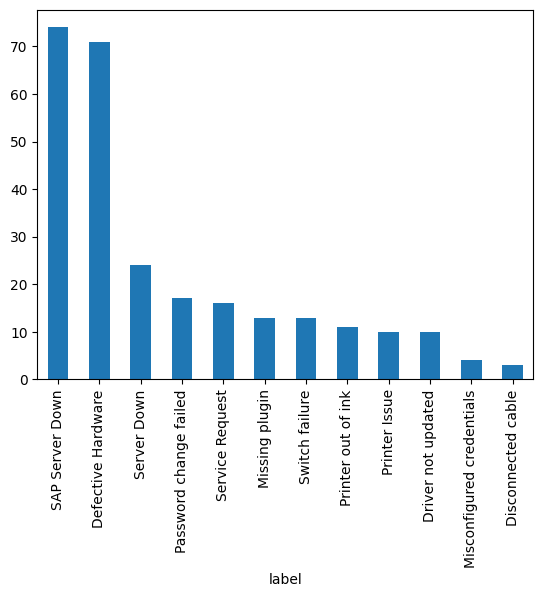

In [9]:
import kagglehub
macimottin_it_incidents_path = kagglehub.dataset_download('macimottin/it-incidents')

import matplotlib as plt
import pandas as pd

incidents_test = pd.read_excel(macimottin_it_incidents_path + "/Incidents_Test_Database.xlsx")

label_counts = incidents_test['label'].value_counts()
label_counts.plot(kind='bar')